In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, classification_report

import tensorflow as tf

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score




from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score




#### Exploring final df

In [22]:
# Load the saved dataset
df = pd.read_csv('processed_data/merged_df.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset loaded: (19536, 41)
Columns: ['gross_FU', 'gross_SC', 'net_FU', 'net_SC', 'time_first_sc_to_first_net_fu', 'electricitybill', 'heatingbill', 'grosscontractsigned', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'mktgparamscore_missing', 'desiredinstallationend_encoded', 'mktg_High', 'mktg_Low', 'mktg_Medium', 'region_High_Performer', 'region_Large_Good', 'region_Medium', 'region_Other', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_FU                        19536 non-null  int64  
 1   gross_SC                        19536 non-null  int64  
 2   net_FU                          19536 non-null  float64
 3   net_SC                          19536 non-null  float64
 4   time_first_sc_to_first_net_fu   19536 non-null  float64
 5   electricitybill                 19536 non-null  float64
 6   heatingbill                     19536 non-null  float64
 7   grosscontractsigned             19536 non-null  float64
 8   selfipa_done                    19536 non-null  int64  
 9   zipregion_missing               19536 non-null  int64  
 10  evaluationtime_missing          19536 non-null  int64  
 11  desiredinstallationend_missing  19536 non-null  int64  
 12  electricitybill_missing         

### Data Understanding of this new df

In [24]:
# Check the target variable
print("=== TARGET VARIABLE ANALYSIS ===")
print(f"Total samples: {len(df)}")
print(f"Conversion rate: {df['grosscontractsigned'].mean():.3f}")
print(f"Converted: {df['grosscontractsigned'].sum():.0f}")
print(f"Not converted: {(len(df) - df['grosscontractsigned'].sum()):.0f}")

=== TARGET VARIABLE ANALYSIS ===
Total samples: 19536
Conversion rate: 0.111
Converted: 2171
Not converted: 17365


In [25]:
# for for this quick test ill drop nans but this shouldnt be here after succesfull data prep
df = df.dropna().copy()

In [26]:
# Separate features from target
target_column = 'grosscontractsigned'
X = df.drop(target_column, axis=1)
y = df[target_column]

print("=== DATA PREPARATION ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {X.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"Any missing values in features: {X.isnull().sum().sum()}")
print(f"Any missing values in target: {y.isnull().sum()}")

=== DATA PREPARATION ===
Features shape: (19536, 40)
Target shape: (19536,)
Feature columns: ['gross_FU', 'gross_SC', 'net_FU', 'net_SC', 'time_first_sc_to_first_net_fu', 'electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing']...
Any missing values in features: 0
Any missing values in target: 0


#### To see any signal at all is present

In [27]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=== TRAIN/TEST SPLIT ===")
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Train conversion rate: {y_train.mean():.3f}")
print(f"Test conversion rate: {y_test.mean():.3f}")

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple logistic regression (NO imbalance handling yet)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Get predictions
y_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]

# Check if there's any signal
auc_score = roc_auc_score(y_test, y_pred_proba)

print("\n=== SIGNAL TEST RESULTS ===")
print(f"AUC-ROC Score: {auc_score:.3f}")
if auc_score > 0.5:
    print("✅ GOOD NEWS: Your features contain useful signal!")
    print("We can proceed with imbalance fixing strategies.")
else:
    print("❌ BAD NEWS: No signal detected. Features need work first.")

=== TRAIN/TEST SPLIT ===
Train size: 15628
Test size: 3908
Train conversion rate: 0.111
Test conversion rate: 0.111

=== SIGNAL TEST RESULTS ===
AUC-ROC Score: 0.951
✅ GOOD NEWS: Your features contain useful signal!
We can proceed with imbalance fixing strategies.


=== TRAIN/TEST SPLIT ===
Train size: 14512
Test size: 3628
Train conversion rate: 0.023
Test conversion rate: 0.023

=== SIGNAL TEST RESULTS ===
AUC-ROC Score: 0.880
✅ GOOD NEWS: Your features contain useful signal!
We can proceed with imbalance fixing strategies.

however lets take a step further to evaluate imbalanced data

In [28]:


# Calculate AUC-PR (more reliable for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)

# Random baseline for comparison
random_baseline = y_test.mean()  # 0.023

print("\n=== DETAILED SIGNAL ANALYSIS ===")
print(f"AUC-ROC: {auc_score:.3f}")
print(f"AUC-PR: {auc_pr:.3f}")
print(f"Random baseline AUC-PR: {random_baseline:.3f}")
print(f"Improvement over random: {auc_pr/random_baseline:.1f}x")

# Look at actual predictions with default 0.5 threshold
y_pred = (y_pred_proba >= 0.5).astype(int)
print(f"\nWith 0.5 threshold:")
print(f"Predicted positives: {y_pred.sum()}")
print(f"Actual positives: {y_test.sum()}")

# Check top 10% of predictions
top_10_percent_threshold = np.percentile(y_pred_proba, 90)
print(f"\nTop 10% analysis:")
print(f"Threshold for top 10%: {top_10_percent_threshold:.3f}")
top_10_mask = y_pred_proba >= top_10_percent_threshold
print(f"Conversion rate in top 10%: {y_test[top_10_mask].mean():.3f}")
print(f"That's {y_test[top_10_mask].mean()/y_test.mean():.1f}x better than average!")


=== DETAILED SIGNAL ANALYSIS ===
AUC-ROC: 0.951
AUC-PR: 0.821
Random baseline AUC-PR: 0.111
Improvement over random: 7.4x

With 0.5 threshold:
Predicted positives: 359
Actual positives: 434.0

Top 10% analysis:
Threshold for top 10%: 0.319
Conversion rate in top 10%: 0.813
That's 7.3x better than average!


=== DETAILED SIGNAL ANALYSIS ===
AUC-ROC: 0.880
AUC-PR: 0.174
Random baseline AUC-PR: 0.023
Improvement over random: 7.4x

With 0.5 threshold:
Predicted positives: 2
Actual positives: 85.0

Top 10% analysis:
Threshold for top 10%: 0.052
Conversion rate in top 10%: 0.132
That's 5.6x better than average!

## Potential data leakage

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_FU                        19536 non-null  int64  
 1   gross_SC                        19536 non-null  int64  
 2   net_FU                          19536 non-null  float64
 3   net_SC                          19536 non-null  float64
 4   time_first_sc_to_first_net_fu   19536 non-null  float64
 5   electricitybill                 19536 non-null  float64
 6   heatingbill                     19536 non-null  float64
 7   grosscontractsigned             19536 non-null  float64
 8   selfipa_done                    19536 non-null  int64  
 9   zipregion_missing               19536 non-null  int64  
 10  evaluationtime_missing          19536 non-null  int64  
 11  desiredinstallationend_missing  19536 non-null  int64  
 12  electricitybill_missing         

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_feature_importance_leakage(X_train, y_train, feature_names, model=None):
    """
    Comprehensive feature importance analysis to detect data leakage patterns
    """
    
    if model is None:
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)
    
    results = {}
    
    # 1. Built-in feature importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        results['builtin_importance'] = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    
    # 2. Permutation importance (model-agnostic)
    perm_importance = permutation_importance(model, X_train, y_train, 
                                           n_repeats=5, random_state=42, 
                                           scoring='roc_auc')
    
    results['permutation_importance'] = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    return results, model

def detect_temporal_leakage(df, target_col, historical_flag_col):
    """
    Specifically check if model can predict historical vs recent data
    """
    print("=== TEMPORAL LEAKAGE DETECTION ===")
    
    # Create temporal classifier
    temporal_features = df.drop(columns=[target_col, historical_flag_col])
    temporal_target = df[historical_flag_col]
    
    temporal_model = RandomForestClassifier(n_estimators=100, random_state=42)
    temporal_model.fit(temporal_features, temporal_target)
    
    # Check accuracy of predicting historical vs recent
    temporal_accuracy = temporal_model.score(temporal_features, temporal_target)
    print(f"Temporal prediction accuracy: {temporal_accuracy:.3f}")
    
    if temporal_accuracy > 0.7:
        print("🚨 HIGH TEMPORAL LEAKAGE RISK - Model can distinguish historical from recent data")
    elif temporal_accuracy > 0.6:
        print("⚠️  MODERATE TEMPORAL LEAKAGE RISK")
    else:
        print("✅ Low temporal leakage risk")
    
    # Show top temporal features
    temporal_importance = pd.DataFrame({
        'feature': temporal_features.columns,
        'temporal_importance': temporal_model.feature_importances_
    }).sort_values('temporal_importance', ascending=False).head(10)
    
    print("\nTop features for predicting historical vs recent:")
    print(temporal_importance)
    
    return temporal_model, temporal_importance

def analyze_suspicious_patterns(importance_df, threshold=0.1):
    """
    Flag potentially suspicious features based on importance patterns
    """
    print("=== SUSPICIOUS FEATURE ANALYSIS ===")
    
    suspicious_features = []
    top_features = importance_df.head(10)
    
    for _, row in top_features.iterrows():
        feature = row['feature']
        importance = row.get('importance', row.get('importance_mean', 0))
        
        # Flag suspicious patterns
        flags = []
        
        # Very high importance (potential leakage)
        if importance > threshold * 3:
            flags.append("VERY_HIGH_IMPORTANCE")
        
        # Check feature name patterns
        feature_lower = feature.lower()
        if any(keyword in feature_lower for keyword in ['id', 'key', 'index', 'row']):
            flags.append("ID_LIKE")
        
        if any(keyword in feature_lower for keyword in ['date', 'time', 'created', 'updated']):
            flags.append("TEMPORAL")
            
        if any(keyword in feature_lower for keyword in ['target', 'label', 'outcome', 'result']):
            flags.append("TARGET_LIKE")
        
        if flags:
            suspicious_features.append({
                'feature': feature,
                'importance': importance,
                'flags': flags
            })
    
    if suspicious_features:
        print("🚨 SUSPICIOUS FEATURES DETECTED:")
        for item in suspicious_features:
            print(f"  {item['feature']}: {item['importance']:.4f} - {', '.join(item['flags'])}")
    else:
        print("✅ No obviously suspicious features in top 10")
    
    return suspicious_features

def plot_feature_importance(importance_df, title="Feature Importance", top_n=15):
    """
    Create visualization of feature importance
    """
    plt.figure(figsize=(10, 8))
    
    top_features = importance_df.head(top_n)
    importance_col = 'importance' if 'importance' in top_features.columns else 'importance_mean'
    
    # Create horizontal bar plot
    plt.barh(range(len(top_features)), top_features[importance_col])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    
    # Add error bars if available
    if 'importance_std' in top_features.columns:
        plt.errorbar(top_features[importance_col], range(len(top_features)), 
                    xerr=top_features['importance_std'], fmt='none', color='red', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage:
"""
# Prepare your data
# df should have: features + target + is_historical flag

# Run analysis
results, model = analyze_feature_importance_leakage(X_train, y_train, feature_names)

# Check for temporal leakage
temporal_model, temporal_imp = detect_temporal_leakage(df, 'target', 'is_historical')

# Analyze suspicious patterns
suspicious = analyze_suspicious_patterns(results['builtin_importance'])

# Plot results
plot_feature_importance(results['builtin_importance'], "Built-in Feature Importance")
plot_feature_importance(results['permutation_importance'], "Permutation Feature Importance")
"""

print("Feature importance analysis tools ready!")
print("Next steps:")
print("1. Run analyze_feature_importance_leakage() on your model")
print("2. Run detect_temporal_leakage() to check if model can predict historical vs recent")
print("3. Look for features with suspiciously high importance")
print("4. Check if top features are ID-like, temporal, or target-derived")

Feature importance analysis tools ready!
Next steps:
1. Run analyze_feature_importance_leakage() on your model
2. Run detect_temporal_leakage() to check if model can predict historical vs recent
3. Look for features with suspiciously high importance
4. Check if top features are ID-like, temporal, or target-derived


In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

def analyze_feature_importance_and_leakage(df, target_column, problem_type='classification'):
    """
    Comprehensive analysis to detect potential data leakage through feature importance
    and correlation analysis.
    
    Parameters:
    - df: DataFrame with features
    - target_column: name of target variable 
    - problem_type: 'classification' or 'regression'
    """
    
    # Separate features and target
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable: {target_column}")
    print(f"Target distribution:")
    if problem_type == 'classification':
        print(y.value_counts().sort_index())
    else:
        print(f"Mean: {y.mean():.3f}, Std: {y.std():.3f}, Min: {y.min():.3f}, Max: {y.max():.3f}")
    
    # Convert boolean columns to int for analysis
    bool_cols = X.select_dtypes(include=['bool']).columns
    X_numeric = X.copy()
    X_numeric[bool_cols] = X_numeric[bool_cols].astype(int)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_numeric, y, test_size=0.2, random_state=42, stratify=y if problem_type == 'classification' else None
    )
    
    # Fit Random Forest model
    if problem_type == 'classification':
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    else:
        rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    rf.fit(X_train, y_train)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_numeric.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calculate correlations with target
    correlations = []
    p_values = []
    
    for col in X_numeric.columns:
        # Use Spearman correlation (robust to non-linear relationships)
        corr, p_val = spearmanr(X_numeric[col], y)
        correlations.append(abs(corr))  # Use absolute correlation
        p_values.append(p_val)
    
    correlation_df = pd.DataFrame({
        'feature': X_numeric.columns,
        'abs_correlation': correlations,
        'p_value': p_values
    }).sort_values('abs_correlation', ascending=False)
    
    # Combine results
    analysis_results = feature_importance.merge(
        correlation_df, on='feature', how='left'
    )
    
    # Flag potentially problematic features
    # High importance OR high correlation could indicate leakage
    high_importance_threshold = 0.05  # Top features with >5% importance
    high_correlation_threshold = 0.3   # Correlation >0.3 with target
    
    analysis_results['potential_leakage'] = (
        (analysis_results['importance'] > high_importance_threshold) | 
        (analysis_results['abs_correlation'] > high_correlation_threshold)
    )
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Feature Importance (Top 20)
    top_20_importance = feature_importance.head(20)
    axes[0,0].barh(range(len(top_20_importance)), top_20_importance['importance'])
    axes[0,0].set_yticks(range(len(top_20_importance)))
    axes[0,0].set_yticklabels(top_20_importance['feature'])
    axes[0,0].set_xlabel('Feature Importance')
    axes[0,0].set_title('Top 20 Feature Importances (Random Forest)')
    axes[0,0].invert_yaxis()
    
    # Add threshold line
    axes[0,0].axvline(x=high_importance_threshold, color='red', linestyle='--', 
                     label=f'Threshold ({high_importance_threshold})')
    axes[0,0].legend()
    
    # 2. Correlation with Target (Top 20)
    top_20_corr = correlation_df.head(20)
    axes[0,1].barh(range(len(top_20_corr)), top_20_corr['abs_correlation'])
    axes[0,1].set_yticks(range(len(top_20_corr)))
    axes[0,1].set_yticklabels(top_20_corr['feature'])
    axes[0,1].set_xlabel('Absolute Correlation with Target')
    axes[0,1].set_title('Top 20 Feature Correlations with Target')
    axes[0,1].invert_yaxis()
    
    # Add threshold line
    axes[0,1].axvline(x=high_correlation_threshold, color='red', linestyle='--', 
                     label=f'Threshold ({high_correlation_threshold})')
    axes[0,1].legend()
    
    # 3. Importance vs Correlation scatter
    axes[1,0].scatter(analysis_results['importance'], analysis_results['abs_correlation'], alpha=0.6)
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_ylabel('Absolute Correlation with Target')
    axes[1,0].set_title('Feature Importance vs Correlation')
    
    # Add threshold lines
    axes[1,0].axhline(y=high_correlation_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1,0].axvline(x=high_importance_threshold, color='red', linestyle='--', alpha=0.7)
    
    # Highlight potential leakage points
    potential_leakage = analysis_results[analysis_results['potential_leakage']]
    if len(potential_leakage) > 0:
        axes[1,0].scatter(potential_leakage['importance'], potential_leakage['abs_correlation'], 
                         color='red', s=100, alpha=0.8, label='Potential Leakage')
        axes[1,0].legend()
    
    # 4. Distribution of feature importance
    axes[1,1].hist(analysis_results['importance'], bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(x=high_importance_threshold, color='red', linestyle='--', 
                     label=f'Threshold ({high_importance_threshold})')
    axes[1,1].set_xlabel('Feature Importance')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Feature Importance')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*80)
    print("POTENTIAL DATA LEAKAGE ANALYSIS")
    print("="*80)
    
    suspicious_features = analysis_results[analysis_results['potential_leakage']].head(10)
    
    if len(suspicious_features) > 0:
        print(f"\n⚠️  Found {len(suspicious_features)} potentially suspicious features:")
        print(f"{'Feature':<35} {'Importance':<12} {'Abs_Corr':<10} {'P-value':<10}")
        print("-" * 70)
        
        for _, row in suspicious_features.iterrows():
            print(f"{row['feature']:<35} {row['importance']:<12.4f} {row['abs_correlation']:<10.4f} {row['p_value']:<10.4f}")
    
    # Specific checks based on column names that often indicate leakage
    print("\n" + "="*80)
    print("COLUMN NAME ANALYSIS (Common Leakage Patterns)")
    print("="*80)
    
    leakage_keywords = ['outcome', 'result', 'target', 'label', 'success', 'conversion', 
                       'signed', 'contract', 'deal', 'won', 'lost', 'final']
    
    for keyword in leakage_keywords:
        matching_cols = [col for col in X.columns if keyword.lower() in col.lower()]
        if matching_cols:
            print(f"\n🚨 Columns containing '{keyword}':")
            for col in matching_cols:
                importance = analysis_results[analysis_results['feature'] == col]['importance'].iloc[0]
                correlation = analysis_results[analysis_results['feature'] == col]['abs_correlation'].iloc[0]
                print(f"  - {col}: Importance={importance:.4f}, Correlation={correlation:.4f}")
    
    # Model performance (as sanity check)
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    
    print(f"\n" + "="*80)
    print("MODEL PERFORMANCE (Sanity Check)")
    print("="*80)
    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score:  {test_score:.4f}")
    print(f"Difference:  {train_score - test_score:.4f}")
    
    if train_score - test_score > 0.1:
        print("⚠️  Large train-test gap suggests potential overfitting or leakage!")
    
    if test_score > 0.95:
        print("⚠️  Suspiciously high performance - check for data leakage!")
    
    return analysis_results, rf

# Example usage:
# Assuming your target variable is one of the columns in your DataFrame
# You'll need to specify which column is your target variable

# For classification (if target is binary/categorical):
# results, model = analyze_feature_importance_and_leakage(df, 'your_target_column', 'classification')

# For regression (if target is continuous):
# results, model = analyze_feature_importance_and_leakage(df, 'your_target_column', 'regression')

print("Ready to analyze! Please specify your target column and run:")
print("results, model = analyze_feature_importance_and_leakage(df, 'your_target_column', 'classification')")
print("\nBased on your column names, these look suspicious for potential leakage:")
print("- grosscontractsigned (sounds like the outcome)")
print("- Any columns with 'outcome' in the name")
print("- first_bc_outcome_encoded, last_bc_outcome_encoded")
print("- selfipa_done (might be post-outcome)")

Ready to analyze! Please specify your target column and run:
results, model = analyze_feature_importance_and_leakage(df, 'your_target_column', 'classification')

Based on your column names, these look suspicious for potential leakage:
- grosscontractsigned (sounds like the outcome)
- Any columns with 'outcome' in the name
- first_bc_outcome_encoded, last_bc_outcome_encoded
- selfipa_done (might be post-outcome)


Dataset shape: (19536, 41)
Target variable: grosscontractsigned
Target distribution:
grosscontractsigned
0.0    17365
1.0     2171
Name: count, dtype: int64


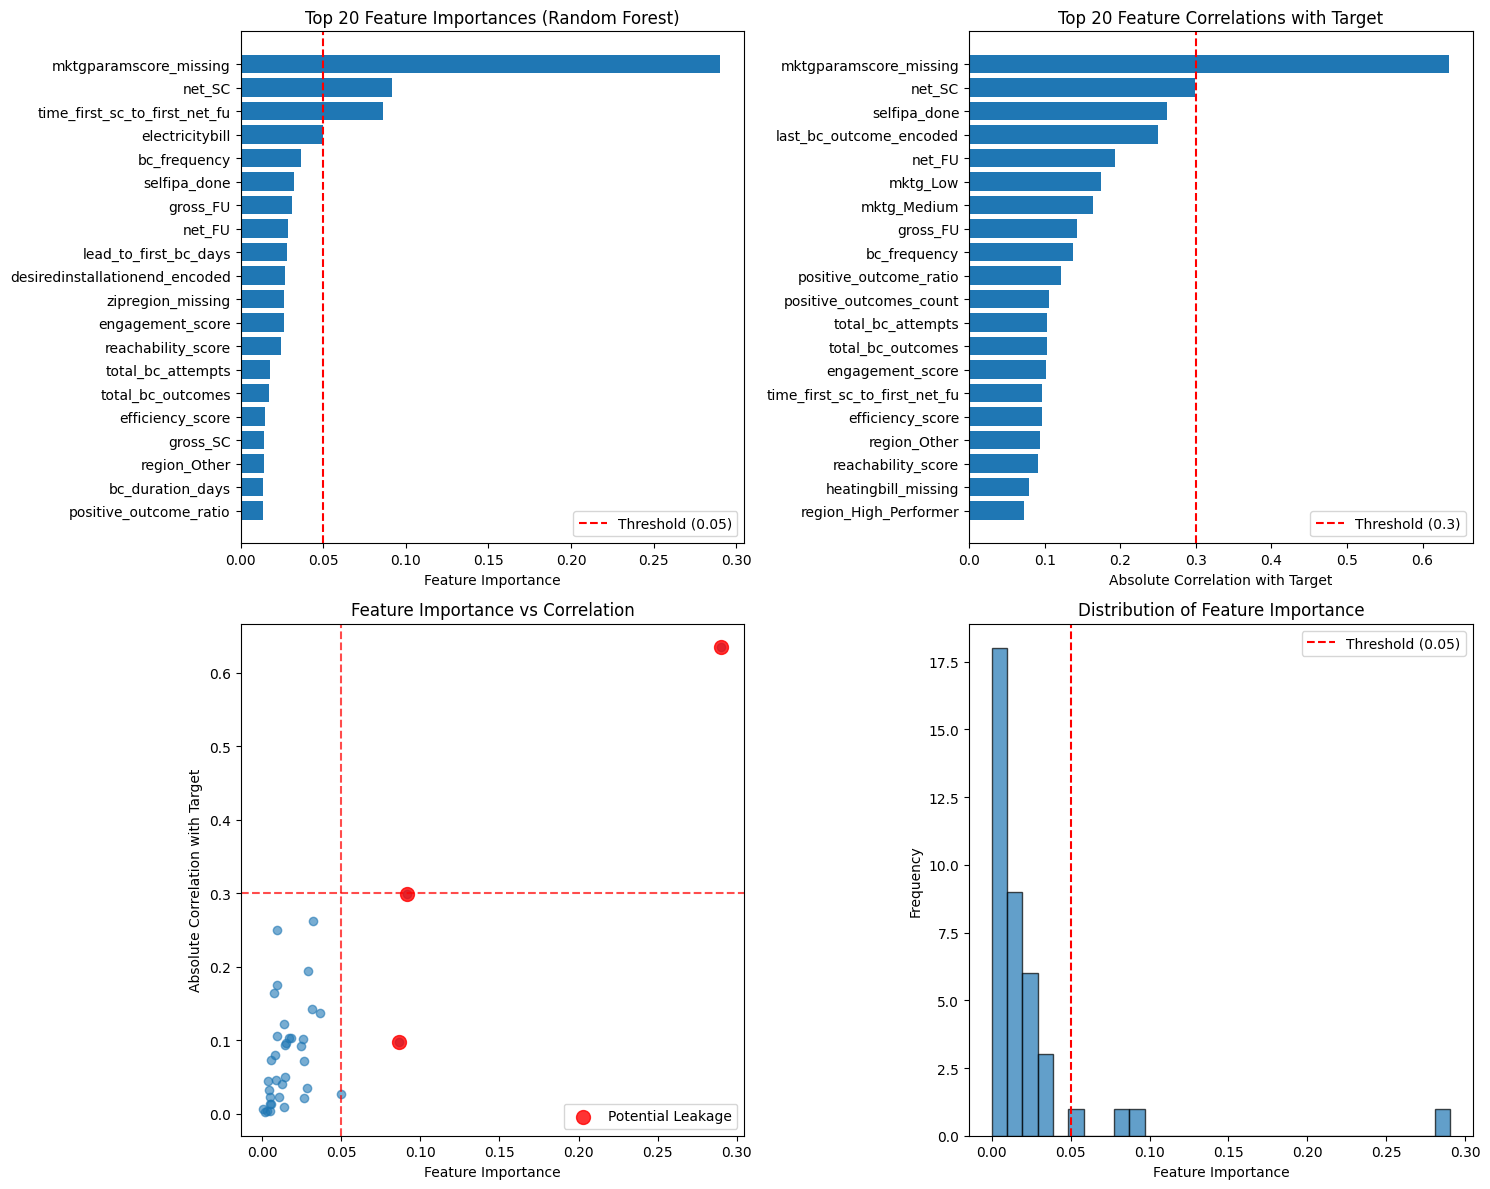


POTENTIAL DATA LEAKAGE ANALYSIS

⚠️  Found 3 potentially suspicious features:
Feature                             Importance   Abs_Corr   P-value   
----------------------------------------------------------------------
mktgparamscore_missing              0.2904       0.6347     0.0000    
net_SC                              0.0913       0.2993     0.0000    
time_first_sc_to_first_net_fu       0.0864       0.0968     0.0000    

COLUMN NAME ANALYSIS (Common Leakage Patterns)

🚨 Columns containing 'outcome':
  - total_bc_outcomes: Importance=0.0171, Correlation=0.1029
  - positive_outcomes_count: Importance=0.0094, Correlation=0.1062
  - negative_outcomes_count: Importance=0.0052, Correlation=0.0132
  - noshow_outcomes_count: Importance=0.0000, Correlation=nan
  - positive_outcome_ratio: Importance=0.0136, Correlation=0.1219
  - negative_outcome_ratio: Importance=0.0055, Correlation=0.0135
  - noshow_outcome_ratio: Importance=0.0000, Correlation=nan
  - outcome_trend: Importance=0.003

In [35]:
results, model = analyze_feature_importance_and_leakage(df, 'grosscontractsigned', 'classification')

In [ ]:
# Check the relationship between missingness and target
# will use this in the thesis to refer
print("Missingness vs Contract Signing Crosstab:")
print(pd.crosstab(df['mktgparamscore_missing'], df['grosscontractsigned'], normalize='columns'))

print("\nPercentages:")
missing_vs_target = pd.crosstab(df['mktgparamscore_missing'], df['grosscontractsigned'], normalize='index') * 100
print(missing_vs_target)

Missingness vs Contract Signing Crosstab:
grosscontractsigned         0.0       1.0
mktgparamscore_missing                   
0                       0.95036  0.286043
1                       0.04964  0.713957

Percentages:
grosscontractsigned           0.0        1.0
mktgparamscore_missing                      
0                       96.373511   3.626489
1                       35.737977  64.262023


Dataset shape: (19536, 37)
Target variable: grosscontractsigned
Target distribution:
grosscontractsigned
0.0    17365
1.0     2171
Name: count, dtype: int64


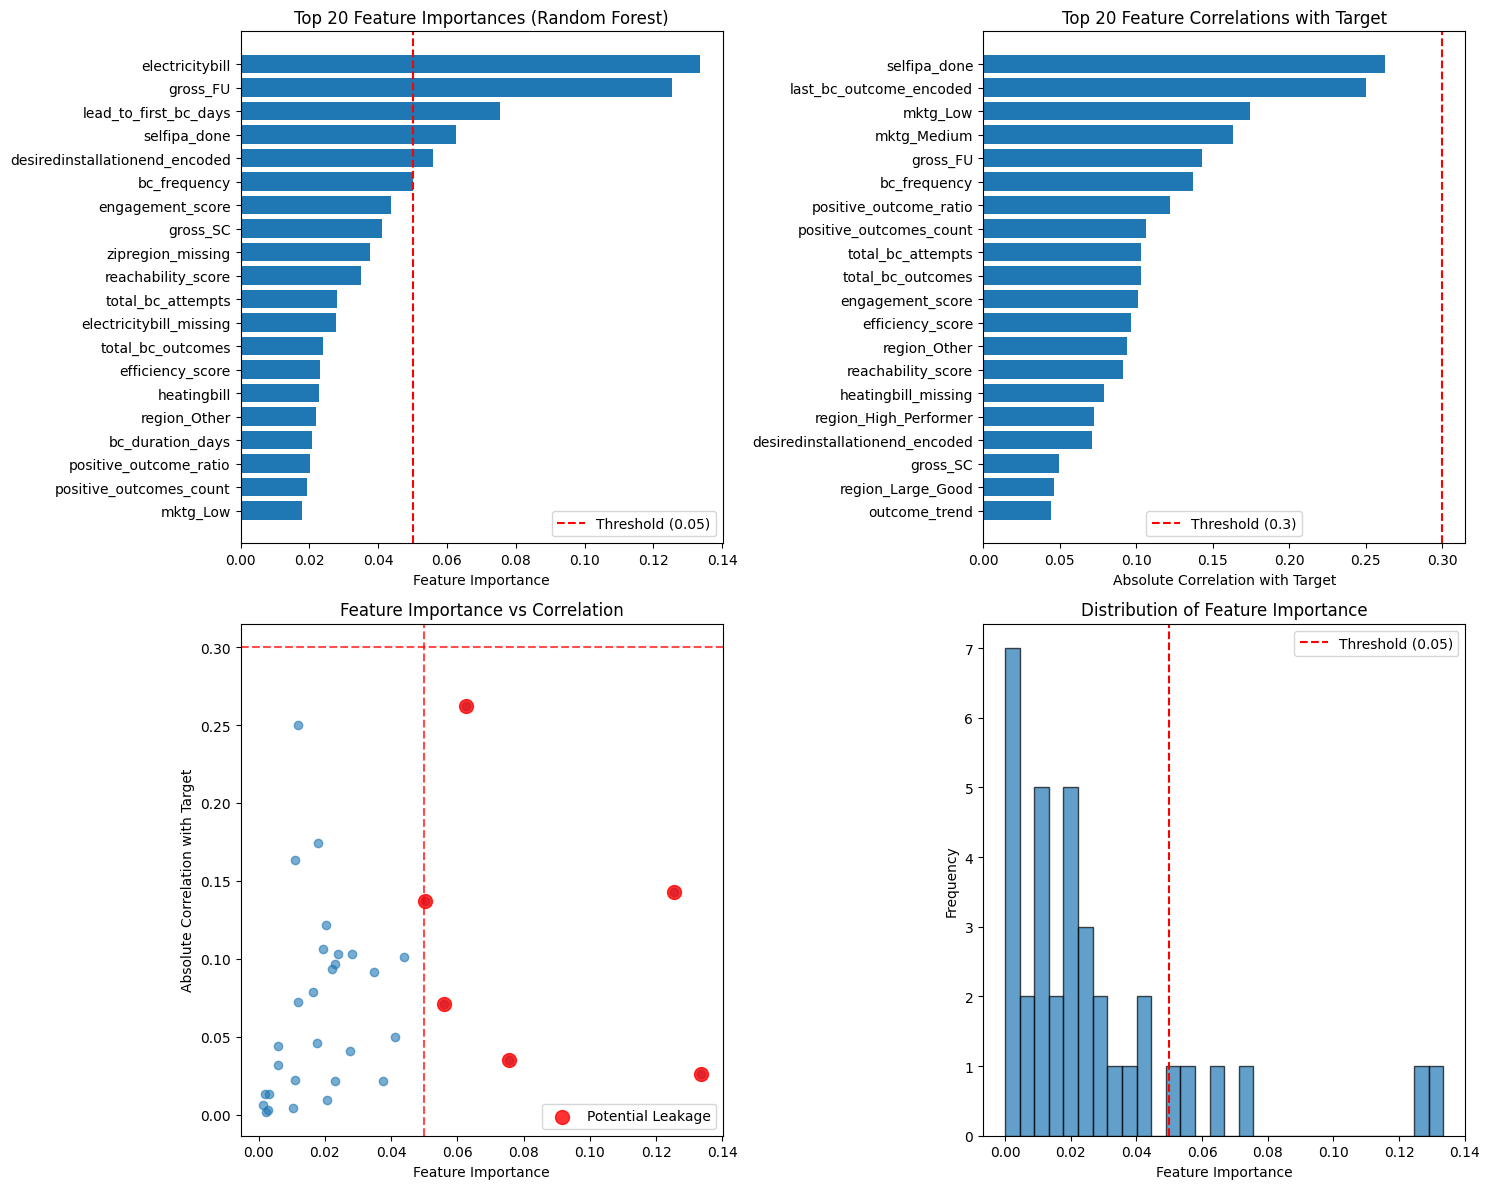


POTENTIAL DATA LEAKAGE ANALYSIS

⚠️  Found 6 potentially suspicious features:
Feature                             Importance   Abs_Corr   P-value   
----------------------------------------------------------------------
electricitybill                     0.1335       0.0260     0.0003    
gross_FU                            0.1253       0.1429     0.0000    
lead_to_first_bc_days               0.0756       0.0350     0.0000    
selfipa_done                        0.0626       0.2625     0.0000    
desiredinstallationend_encoded      0.0560       0.0708     0.0000    
bc_frequency                        0.0501       0.1371     0.0000    

COLUMN NAME ANALYSIS (Common Leakage Patterns)

🚨 Columns containing 'outcome':
  - total_bc_outcomes: Importance=0.0238, Correlation=0.1029
  - positive_outcomes_count: Importance=0.0194, Correlation=0.1062
  - negative_outcomes_count: Importance=0.0018, Correlation=0.0132
  - noshow_outcomes_count: Importance=0.0000, Correlation=nan
  - positive_ou

In [37]:
# ry after dropping top 3 leaky 
# Test without the most suspicious features
leaky_features = ['mktgparamscore_missing', 'net_SC', 'net_FU', 'time_first_sc_to_first_net_fu']
df_clean = df.drop(columns=leaky_features)
results_clean, model_clean = analyze_feature_importance_and_leakage(df_clean, 'grosscontractsigned', 'classification')

🎯 TARGET: grosscontractsigned (binary classification)
🔍 Analyzing for potential data leakage...

⚠️  HIGHLY SUSPICIOUS FEATURES (likely temporal leakage):
These features appear to be derived from business contact outcomes that happen AFTER contract signing:
BC Outcome Features (🚨 HIGH LEAKAGE RISK):
  - total_bc_outcomes
  - positive_outcomes_count
  - negative_outcomes_count
  - noshow_outcomes_count
  - positive_outcome_ratio
  - negative_outcome_ratio
  - noshow_outcome_ratio
  - outcome_trend
  - persistence_after_negative
  - first_bc_outcome_encoded
  - last_bc_outcome_encoded

📊 Run the analysis:
results, model = analyze_feature_importance_and_leakage(df, 'grosscontractsigned', 'classification')
Dataset shape: (19536, 41)
Target variable: grosscontractsigned
Target distribution:
grosscontractsigned
0.0    17365
1.0     2171
Name: count, dtype: int64


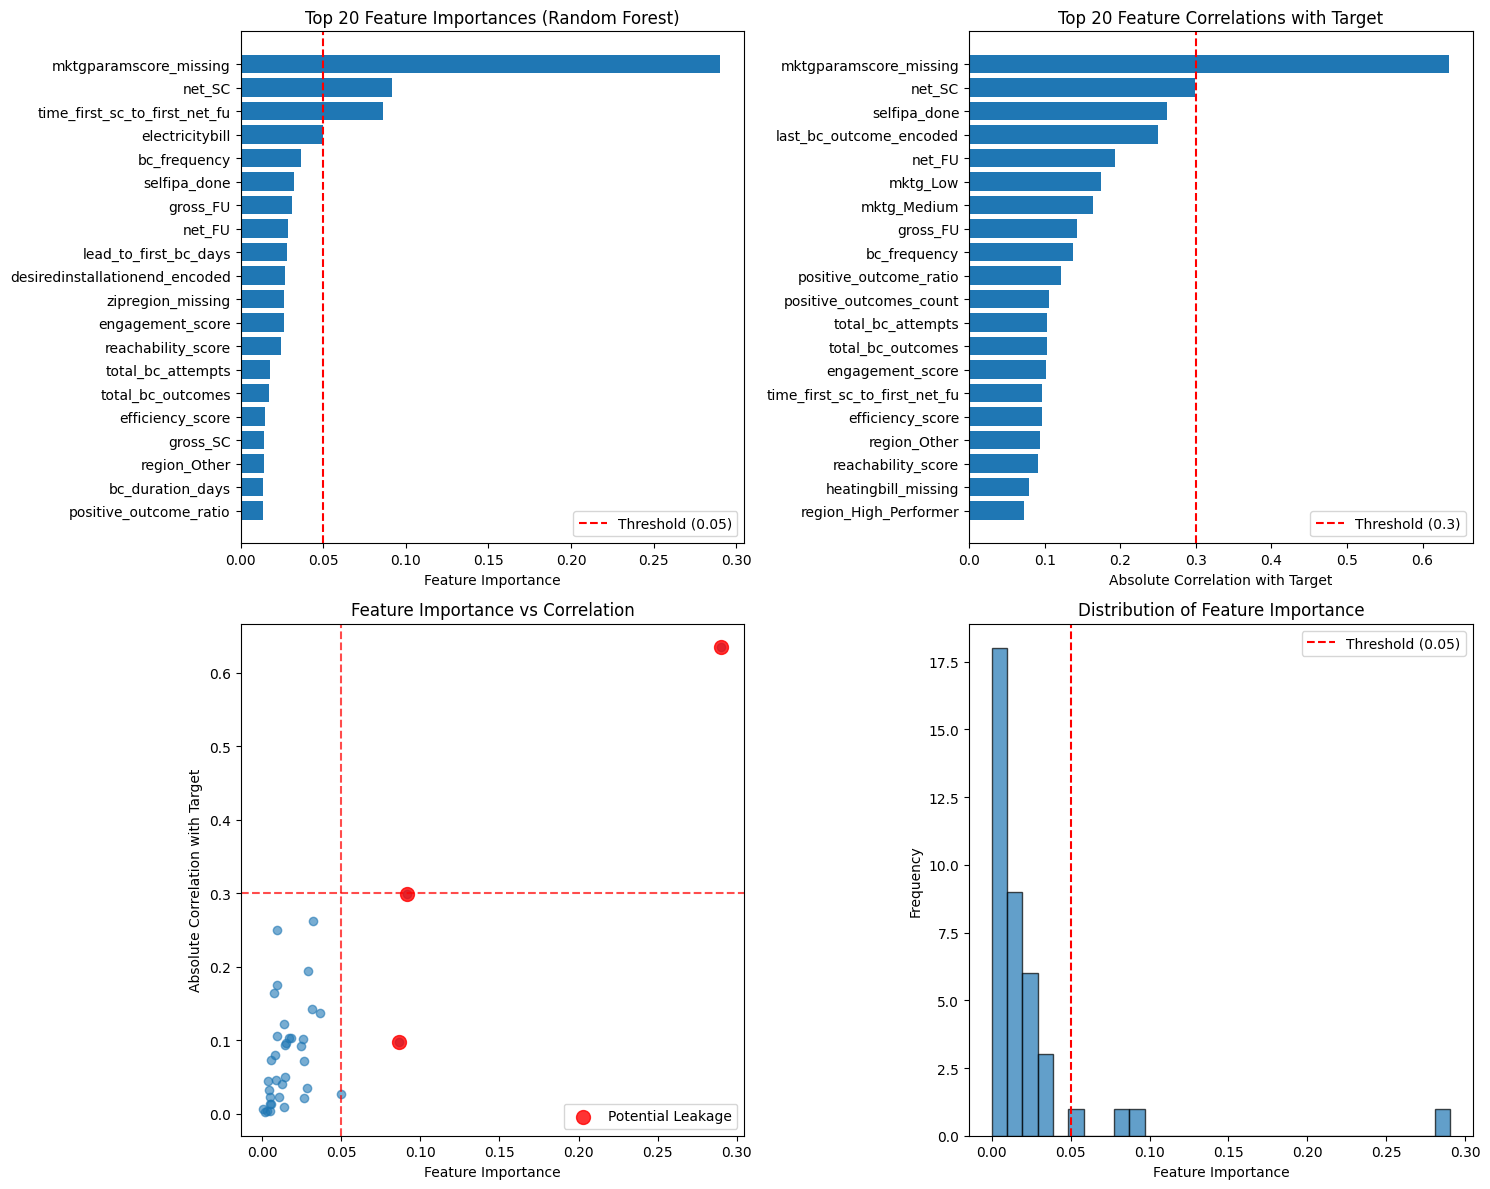


POTENTIAL DATA LEAKAGE ANALYSIS

⚠️  Found 3 potentially suspicious features:
Feature                             Importance   Abs_Corr   P-value   
----------------------------------------------------------------------
mktgparamscore_missing              0.2904       0.6347     0.0000    
net_SC                              0.0913       0.2993     0.0000    
time_first_sc_to_first_net_fu       0.0864       0.0968     0.0000    

COLUMN NAME ANALYSIS (Common Leakage Patterns)

🚨 Columns containing 'outcome':
  - total_bc_outcomes: Importance=0.0171, Correlation=0.1029
  - positive_outcomes_count: Importance=0.0094, Correlation=0.1062
  - negative_outcomes_count: Importance=0.0052, Correlation=0.0132
  - noshow_outcomes_count: Importance=0.0000, Correlation=nan
  - positive_outcome_ratio: Importance=0.0136, Correlation=0.1219
  - negative_outcome_ratio: Importance=0.0055, Correlation=0.0135
  - noshow_outcome_ratio: Importance=0.0000, Correlation=nan
  - outcome_trend: Importance=0.003

In [39]:
# check with more than accuracy 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

def analyze_feature_importance_and_leakage(df, target_column, problem_type='classification'):
    """
    Comprehensive analysis to detect potential data leakage through feature importance
    and correlation analysis.
    
    Parameters:
    - df: DataFrame with features
    - target_column: name of target variable 
    - problem_type: 'classification' or 'regression'
    """
    
    # Separate features and target
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable: {target_column}")
    print(f"Target distribution:")
    if problem_type == 'classification':
        print(y.value_counts().sort_index())
    else:
        print(f"Mean: {y.mean():.3f}, Std: {y.std():.3f}, Min: {y.min():.3f}, Max: {y.max():.3f}")
    
    # Convert boolean columns to int for analysis
    bool_cols = X.select_dtypes(include=['bool']).columns
    X_numeric = X.copy()
    X_numeric[bool_cols] = X_numeric[bool_cols].astype(int)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_numeric, y, test_size=0.2, random_state=42, stratify=y if problem_type == 'classification' else None
    )
    
    # Fit Random Forest model
    if problem_type == 'classification':
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    else:
        rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    rf.fit(X_train, y_train)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_numeric.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calculate correlations with target
    correlations = []
    p_values = []
    
    for col in X_numeric.columns:
        # Use Spearman correlation (robust to non-linear relationships)
        corr, p_val = spearmanr(X_numeric[col], y)
        correlations.append(abs(corr))  # Use absolute correlation
        p_values.append(p_val)
    
    correlation_df = pd.DataFrame({
        'feature': X_numeric.columns,
        'abs_correlation': correlations,
        'p_value': p_values
    }).sort_values('abs_correlation', ascending=False)
    
    # Combine results
    analysis_results = feature_importance.merge(
        correlation_df, on='feature', how='left'
    )
    
    # Flag potentially problematic features
    # High importance OR high correlation could indicate leakage
    high_importance_threshold = 0.05  # Top features with >5% importance
    high_correlation_threshold = 0.3   # Correlation >0.3 with target
    
    analysis_results['potential_leakage'] = (
        (analysis_results['importance'] > high_importance_threshold) | 
        (analysis_results['abs_correlation'] > high_correlation_threshold)
    )
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Feature Importance (Top 20)
    top_20_importance = feature_importance.head(20)
    axes[0,0].barh(range(len(top_20_importance)), top_20_importance['importance'])
    axes[0,0].set_yticks(range(len(top_20_importance)))
    axes[0,0].set_yticklabels(top_20_importance['feature'])
    axes[0,0].set_xlabel('Feature Importance')
    axes[0,0].set_title('Top 20 Feature Importances (Random Forest)')
    axes[0,0].invert_yaxis()
    
    # Add threshold line
    axes[0,0].axvline(x=high_importance_threshold, color='red', linestyle='--', 
                     label=f'Threshold ({high_importance_threshold})')
    axes[0,0].legend()
    
    # 2. Correlation with Target (Top 20)
    top_20_corr = correlation_df.head(20)
    axes[0,1].barh(range(len(top_20_corr)), top_20_corr['abs_correlation'])
    axes[0,1].set_yticks(range(len(top_20_corr)))
    axes[0,1].set_yticklabels(top_20_corr['feature'])
    axes[0,1].set_xlabel('Absolute Correlation with Target')
    axes[0,1].set_title('Top 20 Feature Correlations with Target')
    axes[0,1].invert_yaxis()
    
    # Add threshold line
    axes[0,1].axvline(x=high_correlation_threshold, color='red', linestyle='--', 
                     label=f'Threshold ({high_correlation_threshold})')
    axes[0,1].legend()
    
    # 3. Importance vs Correlation scatter
    axes[1,0].scatter(analysis_results['importance'], analysis_results['abs_correlation'], alpha=0.6)
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_ylabel('Absolute Correlation with Target')
    axes[1,0].set_title('Feature Importance vs Correlation')
    
    # Add threshold lines
    axes[1,0].axhline(y=high_correlation_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1,0].axvline(x=high_importance_threshold, color='red', linestyle='--', alpha=0.7)
    
    # Highlight potential leakage points
    potential_leakage = analysis_results[analysis_results['potential_leakage']]
    if len(potential_leakage) > 0:
        axes[1,0].scatter(potential_leakage['importance'], potential_leakage['abs_correlation'], 
                         color='red', s=100, alpha=0.8, label='Potential Leakage')
        axes[1,0].legend()
    
    # 4. Distribution of feature importance
    axes[1,1].hist(analysis_results['importance'], bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(x=high_importance_threshold, color='red', linestyle='--', 
                     label=f'Threshold ({high_importance_threshold})')
    axes[1,1].set_xlabel('Feature Importance')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Feature Importance')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*80)
    print("POTENTIAL DATA LEAKAGE ANALYSIS")
    print("="*80)
    
    suspicious_features = analysis_results[analysis_results['potential_leakage']].head(10)
    
    if len(suspicious_features) > 0:
        print(f"\n⚠️  Found {len(suspicious_features)} potentially suspicious features:")
        print(f"{'Feature':<35} {'Importance':<12} {'Abs_Corr':<10} {'P-value':<10}")
        print("-" * 70)
        
        for _, row in suspicious_features.iterrows():
            print(f"{row['feature']:<35} {row['importance']:<12.4f} {row['abs_correlation']:<10.4f} {row['p_value']:<10.4f}")
    
    # Specific checks based on column names that often indicate leakage
    print("\n" + "="*80)
    print("COLUMN NAME ANALYSIS (Common Leakage Patterns)")
    print("="*80)
    
    leakage_keywords = ['outcome', 'result', 'target', 'label', 'success', 'conversion', 
                       'signed', 'contract', 'deal', 'won', 'lost', 'final']
    
    for keyword in leakage_keywords:
        matching_cols = [col for col in X.columns if keyword.lower() in col.lower()]
        if matching_cols:
            print(f"\n🚨 Columns containing '{keyword}':")
            for col in matching_cols:
                importance = analysis_results[analysis_results['feature'] == col]['importance'].iloc[0]
                correlation = analysis_results[analysis_results['feature'] == col]['abs_correlation'].iloc[0]
                print(f"  - {col}: Importance={importance:.4f}, Correlation={correlation:.4f}")
    
    # Comprehensive model performance evaluation
    from sklearn.metrics import (classification_report, confusion_matrix, 
                                precision_recall_curve, roc_auc_score, 
                                average_precision_score)
    
    # Get predictions
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    if problem_type == 'classification':
        y_train_proba = rf.predict_proba(X_train)[:, 1]
        y_test_proba = rf.predict_proba(X_test)[:, 1]
    
    print(f"\n" + "="*80)
    print("COMPREHENSIVE MODEL PERFORMANCE")
    print("="*80)
    
    # Basic accuracy scores
    train_accuracy = rf.score(X_train, y_train)
    test_accuracy = rf.score(X_test, y_test)
    
    print(f"📊 ACCURACY SCORES:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy:  {test_accuracy:.4f}")
    print(f"Difference:     {train_accuracy - test_accuracy:.4f}")
    
    if problem_type == 'classification':
        # Class distribution
        print(f"\n📈 CLASS DISTRIBUTION:")
        train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
        test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
        print(f"Train: {dict(train_dist)}")
        print(f"Test:  {dict(test_dist)}")
        
        # ROC AUC and Precision-Recall AUC
        train_roc_auc = roc_auc_score(y_train, y_train_proba)
        test_roc_auc = roc_auc_score(y_test, y_test_proba)
        train_pr_auc = average_precision_score(y_train, y_train_proba)
        test_pr_auc = average_precision_score(y_test, y_test_proba)
        
        print(f"\n🎯 AUC SCORES:")
        print(f"Train ROC-AUC: {train_roc_auc:.4f}")
        print(f"Test ROC-AUC:  {test_roc_auc:.4f}")
        print(f"Train PR-AUC:  {train_pr_auc:.4f}")
        print(f"Test PR-AUC:   {test_pr_auc:.4f}")
        
        # Detailed classification report
        print(f"\n📋 TEST SET CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_test_pred))
        
        # Confusion matrix
        print(f"\n🔢 CONFUSION MATRIX (Test Set):")
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"                 Predicted")
        print(f"               0      1")
        print(f"Actual    0   {cm[0,0]:4d}   {cm[0,1]:4d}")
        print(f"          1   {cm[1,0]:4d}   {cm[1,1]:4d}")
        
        # Calculate business metrics
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n💼 BUSINESS METRICS:")
        print(f"Precision (% of predicted contracts that actually sign): {precision:.3f}")
        print(f"Recall (% of actual signers correctly identified):       {recall:.3f}")
        print(f"Specificity (% of non-signers correctly identified):    {specificity:.3f}")
        print(f"F1-Score (harmonic mean of precision & recall):         {f1:.3f}")
    
    # Leakage warning flags
    print(f"\n⚠️  LEAKAGE WARNING FLAGS:")
    
    if train_accuracy - test_accuracy > 0.1:
        print("🚨 Large train-test accuracy gap suggests overfitting or leakage!")
    
    if problem_type == 'classification':
        if test_roc_auc > 0.95:
            print("🚨 Suspiciously high ROC-AUC - check for data leakage!")
        if test_accuracy > 0.95:
            print("🚨 Suspiciously high accuracy - check for data leakage!")
        if test_pr_auc > 0.90:
            print("🚨 Suspiciously high Precision-Recall AUC - check for data leakage!")
        
        # Check if model is too good to be true for business context
        if test_roc_auc > 0.85 and test_accuracy > 0.85:
            print("🤔 Very high performance - validate this is realistic for your business problem")
    
    if train_accuracy - test_accuracy < 0.02 and test_accuracy > 0.90:
        print("🚨 Perfect generalization with high accuracy is suspicious - check for leakage!")
    
    return analysis_results, rf

# Run the analysis for your specific case
print("🎯 TARGET: grosscontractsigned (binary classification)")
print("🔍 Analyzing for potential data leakage...")
print("\n⚠️  HIGHLY SUSPICIOUS FEATURES (likely temporal leakage):")
print("These features appear to be derived from business contact outcomes that happen AFTER contract signing:")

suspicious_bc_features = [
    'total_bc_outcomes', 'positive_outcomes_count', 'negative_outcomes_count', 
    'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio',
    'noshow_outcome_ratio', 'outcome_trend', 'persistence_after_negative',
    'first_bc_outcome_encoded', 'last_bc_outcome_encoded'
]

print("BC Outcome Features (🚨 HIGH LEAKAGE RISK):")
for feature in suspicious_bc_features:
    print(f"  - {feature}")

print("\n📊 Run the analysis:")
print("results, model = analyze_feature_importance_and_leakage(df, 'grosscontractsigned', 'classification')")

# Automatically run the analysis if df exists in the environment
try:
    if 'df' in locals() or 'df' in globals():
        results, model = analyze_feature_importance_and_leakage(df, 'grosscontractsigned', 'classification')
except NameError:
    print("\n💡 lol")